# Import Data

In [ ]:
! pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports

# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from keras.preprocessing.sequence import pad_sequences
# from pytorch_pretrained_bert import BertTokenizer, BertConfig
# from tqdm import tqdm, trange

import io
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

!pip install scikit-plot
import scikitplot as skplt
# import sklearn
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 

import torch
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification


## Load finBERT required packages
!pip install torch torchvision
!pip install transformers
!pip install torch==1.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# from transformers import AutoTokenizer, AutoModelForSequenceClassification

# # Simple Transformers
# from sklearn.model_selection import train_test_split
# !pip install simpletransformers
# from simpletransformers.classification import ClassificationModel, ClassificationArgs

# from sklearn.model_selection import train_test_split # in first cell
!pip install simpletransformers
!pip install transformers>=4.0.0 #==3.5.1
from simpletransformers.classification import ClassificationModel, ClassificationArgs

     |████████████████████████████████| 133kB 12.8MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 133kB 27.7MB/s 
     |████████████████████████████████| 7.0MB 24.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
ERROR: botocore 1.19.30 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 1.4MB 14.0MB/s 
     |████████████████████████████████| 890kB 53.5MB/s 
     |████████████████████████████████| 2.9MB 44.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bad129186eaeb8e7f15cc6705fb0d2e26008cae16aab07ef50dd2889f5249385
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 225kB 

In [ ]:
FOMC_df = pd.read_csv('/content/sample_data/data_for_colab.csv')

In [ ]:
FOMC_df.head()

,FOMC_date,document_type,document_data_512,document_data_wo_stopwords_512,press_conference,release_date,label_market,label_FED,label_LM,label_LM_512
0,2006-01-31,minutes,account messrs oliner and slifman associate di...,messrs moskow poole hoenig alternate members F...,0,2006-02-21,1,1,0,1
1,2006-01-31,statement,for immediate release share the FOMC decided t...,immediate release share FOMC decided today rai...,0,2006-01-31,1,1,2,2
2,2000-10-03,statement,utilization of the pool of available workers r...,immediate release FOMC meeting today decided m...,0,2000-10-03,0,2,2,1
3,2000-10-03,minutes,indexes of stock market prices declined somewh...,though previous policy tightening actions yet ...,0,2000-11-16,0,2,0,0
4,2000-03-21,statement,growth and of the information currently availa...,raise target federal funds rate 25 basis point...,0,2000-03-21,0,2,0,1


In [ ]:
FOMC_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   FOMC_date                       400 non-null    object
 1   document_type                   400 non-null    object
 2   document_data_512               400 non-null    object
 3   document_data_wo_stopwords_512  400 non-null    object
 4   press_conference                400 non-null    int64 
 5   release_date                    400 non-null    object
 6   label_market                    400 non-null    int64 
 7   label_FED                       400 non-null    int64 
 8   label_LM                        400 non-null    int64 
 9   label_LM_512                    400 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 31.4+ KB


### Function to Convert Label Into to Label String

In [ ]:
def label_to_string(label_int):
    label_string = 'neutral'
    if label_int == 0:
        label_string = 'negative'
    elif label_int == 2:
        label_string = 'positive'
    return label_string
    
FOMC_df['str_label_market'] = FOMC_df['label_market'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_FED'] = FOMC_df['label_FED'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_LM'] = FOMC_df['label_LM'].apply(lambda score: label_to_string(score))
FOMC_df['str_label_LM_512'] = FOMC_df['label_LM_512'].apply(lambda score: label_to_string(score))


### Market Label vs Fed Label vs LM Label


In [ ]:
print('Market Label Counts')
print(FOMC_df["str_label_market"].value_counts())
print("\n-----------------------------\n")

print('Fed Label Counts')
print(FOMC_df["str_label_FED"].value_counts())
print("\n-----------------------------\n")

print('LM Label Counts')
print(FOMC_df["str_label_LM_512"].value_counts())
print("\n-----------------------------\n")

Market Label Counts
neutral     255
negative    125
positive     20
Name: str_label_market, dtype: int64

-----------------------------

Fed Label Counts
positive    167
negative    125
neutral     108
Name: str_label_FED, dtype: int64

-----------------------------

LM Label Counts
negative    168
neutral     126
positive    106
Name: str_label_LM_512, dtype: int64

-----------------------------



In [ ]:
print('Classification Report : LM Label vs Market Label')
classification_rep = classification_report(FOMC_df["label_LM_512"],FOMC_df["label_market"],target_names=['negative', 'neutral', 'positive'])
print(classification_rep)
print("----------------------------------------------------")

print('Classification Report : LM Label vs Fed Label')
classification_rep = classification_report(FOMC_df["label_LM_512"],FOMC_df["label_FED"],target_names=['negative', 'neutral', 'positive'])
print(classification_rep) 
print("----------------------------------------------------")

print('Classification Report : Market Label vs Fed Label')
classification_rep = classification_report(FOMC_df["label_market"],FOMC_df["label_FED"],target_names=['negative', 'neutral', 'positive'])
print(classification_rep) 

Classification Report : LM Label vs Market Label
              precision    recall  f1-score   support

    negative       0.39      0.29      0.33       168
     neutral       0.28      0.56      0.37       126
    positive       0.45      0.08      0.14       106

    accuracy                           0.32       400
   macro avg       0.37      0.31      0.28       400
weighted avg       0.37      0.32      0.30       400

----------------------------------------------------
Classification Report : LM Label vs Fed Label
              precision    recall  f1-score   support

    negative       0.43      0.32      0.37       168
     neutral       0.25      0.21      0.23       126
    positive       0.28      0.43      0.34       106

    accuracy                           0.32       400
   macro avg       0.32      0.32      0.31       400
weighted avg       0.33      0.32      0.32       400

----------------------------------------------------
Classification Report : Market Label 

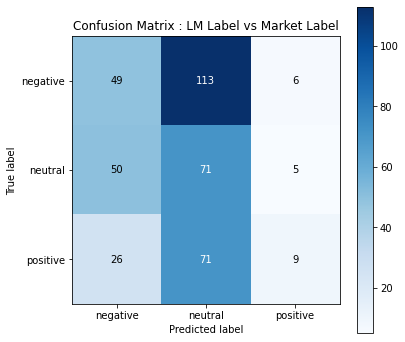


----------------------------------------------------



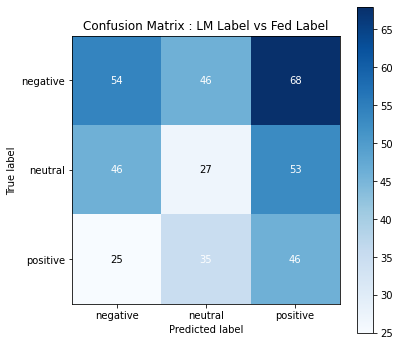


----------------------------------------------------



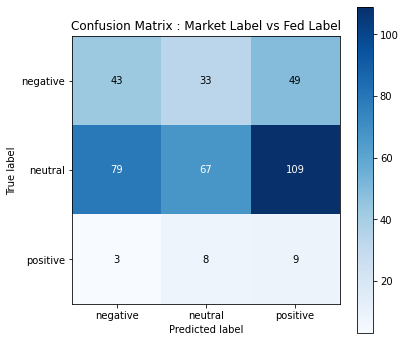

In [ ]:
# print('Confusion Matrix : LM Label vs Market Label')
skplt.metrics.plot_confusion_matrix(FOMC_df["str_label_LM_512"],FOMC_df["str_label_market"],figsize=(6,6))
plt.title('Confusion Matrix : LM Label vs Market Label')
plt.show()
print("\n----------------------------------------------------\n")

# print('Confusion Matrix : LM Label vs Fed Label')
skplt.metrics.plot_confusion_matrix(FOMC_df["str_label_LM_512"],FOMC_df["str_label_FED"],figsize=(6,6))
plt.title('Confusion Matrix : LM Label vs Fed Label')
plt.show()
print("\n----------------------------------------------------\n")

# print('Confusion Matrix : Market Label vs Fed Label')
skplt.metrics.plot_confusion_matrix(FOMC_df["str_label_market"],FOMC_df["str_label_FED"],figsize=(6,6))
plt.title('Confusion Matrix : Market Label vs Fed Label')
plt.show()



In [ ]:
# FOMC_df = FOMC_df.drop_duplicates()
FOMC_minute_df = FOMC_df[FOMC_df['document_type'] == 'minutes']
FOMC_statement_df = FOMC_df[FOMC_df['document_type'] == 'statement']

In [ ]:
# FOMC_model_data_df = FOMC_df[['document_data', 'score_LM']]
FOMC_model_data_df = FOMC_df[['document_data_512', 'label_market']]
FOMC_wo_stopwords_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]
FOMC_model_data_df.head()

,document_data_512,label_market
0,account messrs oliner and slifman associate di...,1
1,for immediate release share the FOMC decided t...,1
2,utilization of the pool of available workers r...,0
3,indexes of stock market prices declined somewh...,0
4,growth and of the information currently availa...,0


## Performance Metrics & Functions


In [ ]:
def calc_f1_score(predictions, labels):
  preds = np.argmax(predictions)
  labels_flatten = labels

  return f1_score(labels_flatten, preds, average='weighted')

In [ ]:
def calc_accuracy_per_class(predictions, labels):
  preds = np.argmax(predictions)
  labels_flatten = labels

  labels_actual = ['Negative', "Neutral", "Postive"]
  idx = 2
  
  for label in np.unique(labels_flatten):
    y_preds = preds[labels_flatten == label]
    y_true = labels_flatten[labels_flatten == label]
    print(f'Class: {labels_actual[idx]}')
    print(f'Accuracy: {len(y_preds[y_preds == label])/len(y_true)}')

    idx -= 1

# Pretrained FinBERT Model

### Download Pretrained FinBERT Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

#load BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")

In [ ]:
def finBERTModelPreTrained(review_text):
    MAX_LEN = 512
    class_names = ['negative', 'neutral', 'positive']

    encoded_new = tokenizer.encode_plus(
                            review_text,                      # Sentence to encode.
                            add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                            max_length = MAX_LEN,             # Pad & truncate all sentences.
                            padding = 'longest',
                            truncation=True,
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',            # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    input_idst = (encoded_new['input_ids'])
    attention_maskst = (encoded_new['attention_mask'])

    # Convert the lists into tensors.
    input_idst = torch.cat([input_idst], dim=0)
    attention_maskst = torch.cat([attention_maskst], dim=0)

    new_test_output = model(input_idst, token_type_ids=None, 
                          attention_mask=attention_maskst)

    logits = new_test_output[0]
    predicted = logits.detach().numpy()

    # Store predictions
    flat_predictions = np.concatenate(predicted, axis=0)

    # For each sample, pick the label (0 or 1) with the higher score.
    new_predictions = np.argmax(flat_predictions).flatten()

    # return class_names[new_predictions[0]]
    return new_predictions[0]


### FinBERT Pretrained Score on Data WITHOUT Stop Words

In [ ]:
FOMC_df['label_PT_FinBERT_512woStopWords'] = FOMC_df['document_data_wo_stopwords_512'].apply(lambda data: finBERTModelPreTrained(data))


In [ ]:
FOMC_df['str_label_PT_FinBERT_512woStopWords'] = FOMC_df['label_PT_FinBERT_512woStopWords'].apply(lambda score: label_to_string(score))

Pretrained FinBERT Label Counts
document_type  str_label_PT_FinBERT_512woStopWords
minutes        neutral                                154
               positive                                54
               negative                                 9
statement      neutral                                157
               positive                                23
               negative                                 3
Name: str_label_PT_FinBERT_512woStopWords, dtype: int64

-----------------------------------------------------



Text(0.5, 1.0, 'Pretrained FinBERT Label Counts by Document Type')

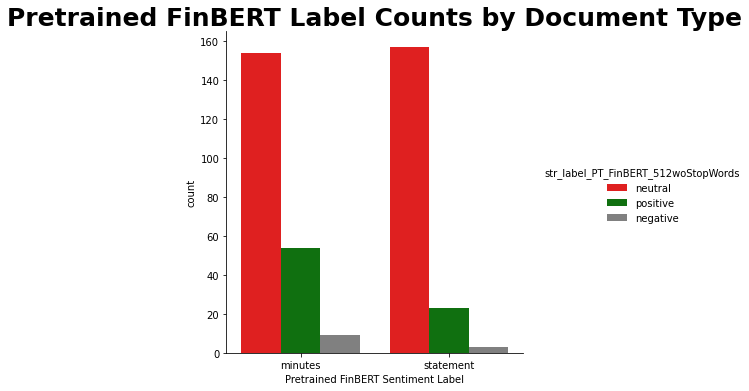

In [ ]:
print("Pretrained FinBERT Label Counts")
print(FOMC_df.groupby('document_type')['str_label_PT_FinBERT_512woStopWords'].value_counts())
print('\n-----------------------------------------------------\n')

ax = sns.catplot(data=FOMC_df, x='document_type', hue='str_label_PT_FinBERT_512woStopWords', kind='count', palette=['red','green','gray'])
plt.xlabel('Pretrained FinBERT Sentiment Label')
plt.title('Pretrained FinBERT Label Counts by Document Type', fontweight='bold', fontsize = 25)

In [ ]:
FOMC_pretrained_finBERT_df = FOMC_df

### FinBERT Confusion Matrixes & Correlations

#### FinBERT WITHOUT Stop Words

##### **FinBERT WITHOUT Stop Words vs Market Label (Acc: .51)

In [ ]:
true_label = FOMC_pretrained_finBERT_df['label_market']
predicted_label = FOMC_pretrained_finBERT_df['label_PT_FinBERT_512woStopWords']


In [ ]:
cm = confusion_matrix(true_label , predicted_label)
cm

array([[  8, 104,  13],
       [  4, 192,  59],
       [  0,  15,   5]])

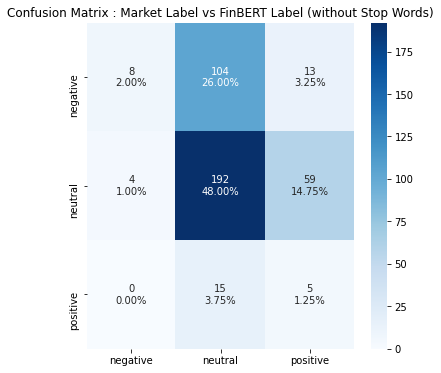

In [ ]:
# skplt.metrics.plot_confusion_matrix(true_label, predicted_label, figsize=(6,6))

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

label_names = ['negative', 'neutral', 'positive']

fig,ax = plt.subplots(figsize=(6,6))
plt.title('Confusion Matrix : FinBERT Label vs Market Label')
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues',ax=ax,xticklabels=label_names,yticklabels=label_names)

In [ ]:
data_label_market = FOMC_pretrained_finBERT_df['str_label_market'].astype('category').cat.codes
predicted_label_FinBERT = FOMC_pretrained_finBERT_df['str_label_PT_FinBERT_512woStopWords'].astype('category').cat.codes

correlation = data_label_market.corr(predicted_label_FinBERT) 

print("All FOMC Documents")
print('Correlation Between Market Label and Pretrained FinBERT Label without Stop Words')
print(correlation)

All FOMC Documents
Correlation Between Market Label and Pretrained FinBERT Label without Stop Words
0.17777774538413943


In [ ]:
print('Classification Report : Market Label vs FinBERT Label (without Stop Words)')
classification_rep = classification_report(data_label_market,predicted_label_FinBERT,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)
print("----------------------------------------------------")


Classification Report : Market Label vs FinBERT Label (without Stop Words)
              precision    recall  f1-score   support

    negative       0.67      0.06      0.12       125
     neutral       0.62      0.75      0.68       255
    positive       0.06      0.25      0.10        20

    accuracy                           0.51       400
   macro avg       0.45      0.36      0.30       400
weighted avg       0.61      0.51      0.47       400

----------------------------------------------------


# Create Train and Test Data

In [ ]:
FOMC_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]
FOMC_model_data_df.head()

,document_type,label_market
0,minutes,1
1,statement,1
2,statement,0
3,minutes,0
4,statement,0


In [ ]:
# from sklearn.model_selection import train_test_split # in first cell

X = FOMC_model_data_df['document_data_wo_stopwords_512']
y = FOMC_model_data_df['label_market']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2020)


In [ ]:
print('X_train.shape',X_train.shape)
print('X_val.shape',X_val.shape)
print('y_train.shape',y_train.shape)
print('y_val.shape',y_val.shape)

X_train.shape (320,)
X_val.shape (80,)
y_train.shape (320,)
y_val.shape (80,)


#### Weight Train/Test Data by Number of Labels

In [ ]:
print('Train Market Label Counts')
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print('Test Market Label Counts')
unique, counts = np.unique(y_val, return_counts=True)
print(dict(zip(unique, counts)))


Train Market Label Counts
{0: 100, 1: 204, 2: 16}
Test Market Label Counts
{0: 25, 1: 51, 2: 4}


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    FOMC_df["document_data_wo_stopwords_512"].values, 
    FOMC_df['label_market'].values,
    test_size=.20,
    stratify=FOMC_df['label_market'].values
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(320,)
(320,)
<class 'numpy.ndarray'>
(80,)


In [ ]:
print('Market Label Counts')
print(FOMC_df["str_label_market"].value_counts())
market_label_counts = FOMC_df["str_label_market"].value_counts()

print('Fed Label Counts')
print(FOMC_df["label_FED"].value_counts())

Market Label Counts
neutral     255
negative    125
positive     20
Name: str_label_market, dtype: int64
Fed Label Counts
2    167
0    125
1    108
Name: label_FED, dtype: int64


In [ ]:
market_label_counts_df = pd.DataFrame(market_label_counts)
market_label_counts_df.columns = ['count']
market_label_counts_df.reset_index(inplace=True)
market_label_counts_df = market_label_counts_df.rename(columns = {'index':'label'})
market_label_counts_df['% of dataset'] = market_label_counts_df['count'] / len(FOMC_df) * 100

In [ ]:
market_label_counts_df

,label,count,% of dataset
0,neutral,255,63.75
1,negative,125,31.25
2,positive,20,5.00


#### Chart to show class breakdown after applying weights

In [ ]:
train_ft, eval_ft = train_test_split(FOMC_df, test_size = 0.2)
train_ft.head()
market_label_counts_train = train_ft["str_label_market"].value_counts()

print('Market Label Counts')
print(train_ft["str_label_market"].value_counts())


Market Label Counts
neutral     205
negative    100
positive     15
Name: str_label_market, dtype: int64


In [ ]:
market_label_counts_train_df = pd.DataFrame(market_label_counts_train)
market_label_counts_train_df.columns = ['count']
market_label_counts_train_df.reset_index(inplace=True)
market_label_counts_train_df = market_label_counts_train_df.rename(columns = {'index':'label'})
market_label_counts_train_df['% of dataset'] = market_label_counts_train_df['count'] / len(FOMC_df) * 100

In [ ]:
market_label_counts_train_df

,label,count,% of dataset
0,neutral,205,51.25
1,negative,100,25.00
2,positive,15,3.75


In [ ]:
# print(train_ft[['document_type',"label_market"].value_counts())
train_ft.groupby(['document_type',"str_label_market"]).count()

FOMC_date  ...  str_label_LM_512
document_type str_label_market             ...                  
minutes       negative                 52  ...                52
              neutral                 108  ...               108
              positive                  9  ...                 9
statement     negative                 48  ...                48
              neutral                  97  ...                97
              positive                  6  ...                 6

[6 rows x 12 columns]

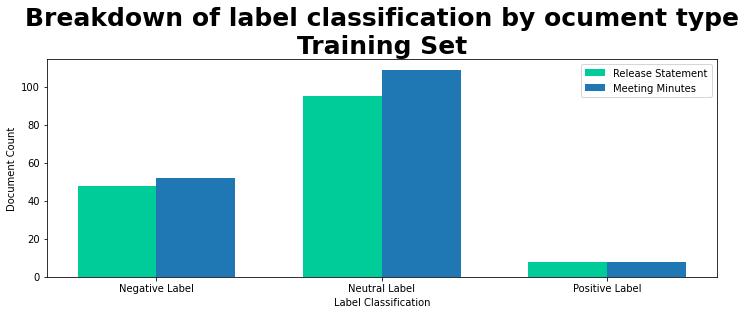

In [ ]:
plt.figure(figsize=(12, 4))
N = 3
ind = np.arange(N) 
width = 0.35  
plt.bar(ind, (48, 95, 8), width, label='Release Statement', color='#00CC99')
plt.bar(ind + width, (52, 109, 8), width,
    label='Meeting Minutes')
plt.xlabel("Label Classification")
plt.ylabel("Document Count")
plt.title("Breakdown of label classification by ocument type\nTraining Set", fontweight='bold', fontsize=25)
plt.xticks(ind + width / 2, ('Negative Label', 'Neutral Label', 'Positive Label'))
plt.legend(loc='best')
plt.show()

# BERT Model

##FT BERT Model with FinBERT Architecture & Trained Weights - WITHOUT Stop Words
https://simpletransformers.ai/docs/usage/

##### Weighted Training Data (WITHOUT Stop Words & Market Label)

In [ ]:
FOMC_model_data_df = FOMC_df[['document_data_wo_stopwords_512', 'label_market']]

train_ft, eval_ft = train_test_split(FOMC_model_data_df, test_size = 0.2, stratify=FOMC_model_data_df['label_market'].values)



In [ ]:
print('X_train.shape',train_ft.shape)
print('X_val.shape',eval_ft.shape)
train_ft.head()

X_train.shape (320, 2)
X_val.shape (80, 2)


,document_data_wo_stopwords_512,label_market
192,immediate release share FOMC decided today kee...,1
154,account wide range information including measu...,0
344,backed securities agency mortgage backed secur...,0
73,immediate release FOMC decided today keep targ...,1
315,organizations market participants reportedly r...,1


In [ ]:
print('Train Market Label Counts')
unique, counts = np.unique(train_ft['label_market'], return_counts=True)
print(dict(zip(unique, counts)))

print('Test Market Label Counts')
unique, counts = np.unique(eval_ft['label_market'], return_counts=True)
print(dict(zip(unique, counts)))


Train Market Label Counts
{0: 100, 1: 204, 2: 16}
Test Market Label Counts
{0: 25, 1: 51, 2: 4}


In [ ]:
train_ft_df = pd.DataFrame({
    'text': train_ft['document_data_wo_stopwords_512'],
    'label': train_ft['label_market']
})

eval_ft_df = pd.DataFrame({
    'text': eval_ft['document_data_wo_stopwords_512'],
    'label': eval_ft['label_market']
})

print(train_ft_df.shape)
print(eval_ft_df.shape)
train_ft_df.head()

(320, 2)
(80, 2)


,text,label
192,immediate release share FOMC decided today kee...,1
154,account wide range information including measu...,0
344,backed securities agency mortgage backed secur...,0
73,immediate release FOMC decided today keep targ...,1
315,organizations market participants reportedly r...,1


In [ ]:
print("Pretrained FinBERT - True Market Label Counts for Middle 512 Words")
print(eval_ft_df['label'].value_counts())
print('\n-----------------------------------------------------\n')

Pretrained FinBERT - True Market Label Counts for Middle 512 Words
1    51
0    25
2     4
Name: label, dtype: int64

-----------------------------------------------------



##### Create a FT BERT Model with FinBERT Arch

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model_args = ClassificationArgs()
model_args.train_batch_size = 2#32 #evalution batch size
# model_args.eval_batch_size = 32
model_args.gradient_accumulation_steps = 8 #The number of training steps to execute before
                                          #performing a optimizer.step(). Effectively increases 
                                          #the training batch size while sacrificing training time 
                                          #to lower memory consumption.
model_args.learning_rate = 3e-5 #learning rate for training
model_args.num_train_epochs = 10 #number of epochs the model will be trained for
model_args.overwrite_output_dir = True #if True, the trained model will be saved to the output_dir
                                        #and will overwrite existing saed models in the same directory
model_args.max_seq_length = 512 #max sequence length the model will support

model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True #print results from evaluation during training.
model_args.do_lower_case = True
model_args.manual_seed = 4

# model_args.use_early_stopping = True
# model_args.early_stopping_delta = 0.1
# model_args.early_stopping_metric = "mcc"
# model_args.early_stopping_metric_minimize = False
# model_args.early_stopping_patience = 3


In [ ]:
class_weights_ft = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_ft_df['label']),
                                                 train_ft_df['label']).tolist()

print(class_weights_ft)

[1.0666666666666667, 0.5228758169934641, 6.666666666666667]


In [ ]:
# WITH CLASS WEIGHTS
# FinBERT_model_tuned = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, weight=class_weights_ft, args=model_args,use_cuda=True)

# NO CLASS WEIGHTS
FinBERT_model_tuned = ClassificationModel('bert', 'ipuneetrathore/bert-base-cased-finetuned-finBERT', num_labels=3, args=model_args,use_cuda=True)


In [ ]:
FinBERT_model_tuned.train_model(train_ft_df, eval_df=eval_ft_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(200,
 {'eval_loss': [1.5232949674129486,
   1.333155232667923,
   1.1401718497276305,
   1.1574153780937195,
   1.224285864830017,
   1.4278105542063713,
   2.2032025545835494,
   2.3745268911123274,
   2.482073336839676,
   2.5178318679332734],
  'global_step': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
  'mcc': [-0.07644677229180592,
   0.10905134655772508,
   0.15518296950749624,
   0.3034722059207579,
   0.28073829815366746,
   0.24771394191218862,
   0.36323552475342546,
   0.2690886424356508,
   0.3174500871014461,
   0.31740512686371547],
  'train_loss': [1.1038591861724854,
   0.6359277367591858,
   0.6513547897338867,
   0.11304620653390884,
   0.5587430596351624,
   0.12126123160123825,
   0.0007532913004979491,
   0.004208656493574381,
   0.0010982367675751448,
   0.00038352893898263574]})

In [ ]:
result, model_outputs, wrong_predictions = FinBERT_model_tuned.eval_model(eval_ft_df, verbose=True)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


##### **FT BERT Model (w/ FinBERT & WITHOUT Stop Words) vs Market Label Results (Acc: .73)

In [ ]:
print(result)
model_outputs[:5]
# for pred in wrong_predictions:
#   print(pred.label, '   :  ', pred.text_a[:100])

{'mcc': 0.3858074489997644, 'eval_loss': 3.039785810559988}


array([[ 6.15625   , -0.78857422, -4.66015625],
       [ 6.19140625,  0.16467285, -5.5703125 ],
       [-0.44287109,  5.22265625, -5.09375   ],
       [ 1.88574219,  4.44140625, -6.359375  ],
       [-1.08105469,  5.63671875, -4.50390625]])

In [ ]:
true = eval_base_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
cm = confusion_matrix(true , predicted)

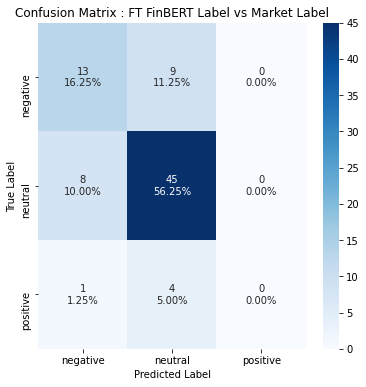

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

label_names = ['negative', 'neutral', 'positive']

fig,ax = plt.subplots(figsize=(6,6))
heatmap = sns.heatmap(cm, annot=labels, fmt="", cmap='Blues',ax=ax,xticklabels=label_names,yticklabels=label_names)
plt.title('Confusion Matrix : FT FinBERT Label vs Market Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
classification_rep = classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.59      0.59      0.59        22
     neutral       0.78      0.85      0.81        53
    positive       0.00      0.00      0.00         5

    accuracy                           0.73        80
   macro avg       0.46      0.48      0.47        80
weighted avg       0.68      0.72      0.70        80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##FT BERT Model - WITHOUT Stop Words
https://simpletransformers.ai/docs/usage/

##### Weighted Training Data

In [2]:
train_ft2, eval_ft2 = train_test_split(FOMC_model_data_df, test_size=0.2, random_state=2020)


train_ft2_df = pd.DataFrame({
    'text': train_ft2['document_data_wo_stopwords_512'],
    'label': train_ft2['label_market']
})

eval_ft2_df = pd.DataFrame({
    'text': eval_ft2['document_data_wo_stopwords_512'],
    'label': eval_ft2['label_market']
})

# print(train_ft_df.shape)
# print(eval_ft_df.shape)
# train_ft_df.head()

##### Create a FT BERT Model with FinBERT Arch

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model_args = ClassificationArgs()
model_args.train_batch_size = 16 #2 #32 #evalution batch size
model_args.gradient_accumulation_steps = 8 #The number of training steps to execute before
                                          #performing a optimizer.step(). Effectively increases 
                                          #the training batch size while sacrificing training time 
                                          #to lower memory consumption.
model_args.learning_rate = 3e-5 #learning rate for training
model_args.num_train_epochs = 6 #number of epochs the model will be trained for
model_args.overwrite_output_dir = True #if True, the trained model will be saved to the output_dir
                                        #and will overwrite existing saed models in the same directory
model_args.max_seq_length = 512 #max sequence length the model will support

model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True #print results from evaluation during training.
model_args.do_lower_case = True
model_args.manual_seed = 4


In [ ]:
# ADDS CLASS WEIGHTS
# BERT_model_tuned = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, weight=class_weights_ft, args=model_args,use_cuda=True)

# No Class Weights
BERT_model_tuned = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, args=model_args,use_cuda=True)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
BERT_model_tuned.train_model(train_ft2_df, eval_df=eval_ft2_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:380: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(200,
 {'eval_loss': [0.8152147918939591,
   0.7912605583667756,
   0.7547284662723541,
   0.7521444335579872,
   0.7001861691474914,
   0.7907815456390381,
   0.7408503994345665,
   0.9182688266038894,
   0.9814739108085633,
   1.0152521103620529],
  'global_step': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
  'mcc': [0.0,
   0.0,
   0.32396006237629044,
   0.2783882738994529,
   0.2968062620677356,
   0.42692955625242673,
   0.4173367238211307,
   0.3961324183894518,
   0.3893250289883381,
   0.3893250289883381],
  'train_loss': [1.0318622589111328,
   0.4272158741950989,
   0.9795262813568115,
   0.17508187890052795,
   0.19370809197425842,
   0.7476764917373657,
   0.06940552592277527,
   0.057173848152160645,
   0.03466220200061798,
   0.02919100597500801]})

In [ ]:
result, model_outputs, wrong_predictions = BERT_model_tuned.eval_model(eval_ft2_df, verbose=True)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:901: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


##### ** FT BERT Model (WITHOUT Stop Words) vs Market Label Results (Acc: .74)

In [ ]:
print(result)
model_outputs[:5]
# for pred in wrong_predictions:
#   print(pred.label, '   :  ', pred.text_a[:100])

{'mcc': 0.38739014697320606, 'eval_loss': 1.3446936659514903}


array([[ 1.73730469, -0.69580078, -0.98388672],
       [-1.9140625 ,  2.15625   , -0.64892578],
       [-1.39648438,  2.35351562, -1.24511719],
       [ 1.24804688,  0.15808105, -1.50878906],
       [-2.15625   ,  2.18164062, -0.43505859]])

In [ ]:
true = eval_ft2_df['label'].tolist()
predicted = []
for arr in model_outputs:
    predicted.append(np.argmax(arr))

In [ ]:
cm = confusion_matrix(true , predicted)

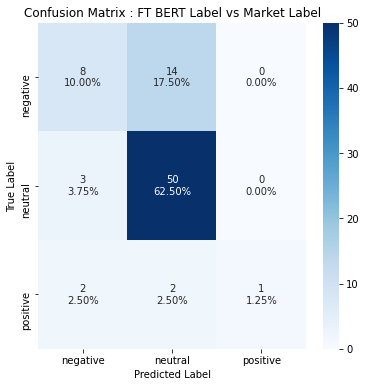

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
label_names = ['negative', 'neutral', 'positive']


fig,ax = plt.subplots(figsize=(6,6))
heatmap =sns.heatmap(cm, annot=labels, fmt="", cmap='Blues',ax=ax,xticklabels=label_names,yticklabels=label_names)
plt.title('Confusion Matrix : FT BERT Label vs Market Label')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
classification_rep = classification_report(true,predicted,target_names=['negative', 'neutral', 'positive'])
print(classification_rep)

              precision    recall  f1-score   support

    negative       0.62      0.36      0.46        22
     neutral       0.76      0.94      0.84        53
    positive       1.00      0.20      0.33         5

    accuracy                           0.74        80
   macro avg       0.79      0.50      0.54        80
weighted avg       0.73      0.74      0.70        80



#Final Results

In [ ]:
import pandas as pd
from IPython.display import HTML



In [ ]:
column_names = ['Model', 'Weighted Precision', 'Weighted Recall', 'Weighted F1-Score', 'Accuracy']
model_name = ['L-M Lexicon', 'Pretrained FinBERT', 'Fine-tuned FinBERT', 'Fine-tuned BERT']
weighted_f1_score = [.42, 0.47, 0.70, 0.70]
accuracy = [.40, 0.51, 0.73, 0.74]
weighted_precision = [.55, 0.61, 0.68, 0.73]
weighted_recall = [.40, 0.51, 0.72, 0.74]

result_df = pd.DataFrame(list(zip(model_name, weighted_precision, weighted_recall, weighted_f1_score,accuracy)), columns=column_names)

In [ ]:
result_df

# styles = [
#     dict(selector="th", props=[("text-align", "center")])]

# html = (result_df.style.set_table_styles(styles))
# html.set_properties(**{'text-align': 'center'}).hide_index()

,Model,Weighted Precision,Weighted Recall,Weighted F1-Score,Accuracy
0,L-M Lexicon,0.55,0.40,0.42,0.40
1,Pretrained FinBERT,0.61,0.51,0.47,0.51
2,Fine-tuned FinBERT,0.68,0.72,0.70,0.73
3,Fine-tuned BERT,0.73,0.74,0.70,0.74
